# Paired integration tutorial

In this notebook we showcase basic Multigrate functionality and integrate a CITE-seq dataset to obtain a joint gene expression and protein abundance representation in a latent space. We use publically available dataset from NeurIPS 2021 workshop https://openproblems.bio/neurips_2021/.

The preprocessed data can be downloaded from https://drive.google.com/drive/folders/1SJeo1OYM__h8vB6dXzGWC8FcLV5fUmgZ?usp=sharing.

In [1]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc
import numpy as np

Global seed set to 0


In [2]:
rna = sc.read('neurips-cite/rna_hvg.h5ad')
rna

AnnData object with n_obs × n_vars = 90261 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [3]:
adt = sc.read('neurips-cite/protein.h5ad')
adt

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

We subset to two sites in this tutorial.

In [4]:
rna = rna[rna.obs['Site'].isin(['site1', 'site2'])]
rna

View of AnnData object with n_obs × n_vars = 41482 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
adt = adt[adt.obs['Site'].isin(['site1', 'site2'])]
adt

View of AnnData object with n_obs × n_vars = 41482 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## Prep the input AnnData object

First, we need to organize anndatas correspoding to different datasets and modalities into 1 anndata object. In this example we have 1 CITE-seq dataset, hence we input 2 anndata objects, 1 for RNA modality, 1 for ADT modality, and specify that they are paired (```groups``` argument).

Notes:
- paired datasets have to have the same .obs_names, i.e. index

In [6]:
# check that obs_names are indeed the same
np.sum(rna.obs_names != adt.obs_names)

0

In [7]:
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [adt]],      # a list of anndata objects per modality, RNA-seq always goes first
    groups = [[0], [0]],          # groups that specify which anndatas are paired
    layers = [['counts'], [None]] # if need to use data from .layers, if None use .X
)
adata

/home/icb/anastasia.litinetskaya/code/multigrate/multigrate/data/_preprocessing.py:43: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas[mod][i].obs["group"] = datasets_groups[i]
/home/icb/anastasia.litinetskaya/code/multigrate/multigrate/data/_preprocessing.py:43: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas[mod][i].obs["group"] = datasets_groups[i]
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 41482 × 4134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'counts'

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA, we need to use NB loss (or ZINB), thus need to calculate `size_factors` first. If using normalized counts and MSE for scRNA, `rna_indices_end` does not need to be specified.

In [8]:
mtg.model.MultiVAE.setup_anndata(
    adata,
    rna_indices_end=4000, # how many features in the rna-seq modality
    categorical_covariate_keys=["batch"]
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 41482 cells, 4134 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 1 extra categorical covariates and 1 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


If categorical (e.g. sex) or continious covariates (e.g. age) are available, and you'd like to learn a latent representation disentangled from these covariates, additionally specify in setup_anndata
```
categorical_covariate_keys: ["batch"],
continuous_covariate_keys: ["age"]
```

Here we want to get rid of batch effect, so we specify  `batch` as a categorical covariate.

# Initialize the model

Define the model here. If using raw counts for RNA-seq, use NB loss, if normalized counts, use MSE. For ADT we use CLR-normalized counts and MSE loss.

In [9]:
model = mtg.model.MultiVAE(
    adata, 
    modality_lengths=[4000, 134], # how many features per modality
    losses=['nb', 'mse'],         # what losses to use for each modality
    loss_coefs={'kl': 1e-6,
               'integ': 1e-2},
    integrate_on="batch",
    z_dim=15,
    cond_dim=10,
    dropout=0.2,
    n_layers_encoders=[1, 1],
)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


# Train the model

Can specify the number of epochs by setting `max_epochs` parameter, default is 500.

In [10]:
model.train(max_epochs=200)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:97: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/icb/anastasia.litinetskaya/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 1/200:   0%|          | 1/200 [00:10<34:11, 10.31s/it, loss=2.07e+03, v_num=1]

Metric elbo_validation improved. New best score: 1986.196


Epoch 2/200:   1%|          | 2/200 [00:19<31:52,  9.66s/it, loss=1.76e+03, v_num=1]

Metric elbo_validation improved by 315.726 >= min_delta = 0.0. New best score: 1670.471


Epoch 3/200:   2%|▏         | 3/200 [00:28<30:24,  9.26s/it, loss=1.56e+03, v_num=1]

Metric elbo_validation improved by 199.748 >= min_delta = 0.0. New best score: 1470.722


Epoch 4/200:   2%|▏         | 4/200 [00:37<30:26,  9.32s/it, loss=1.44e+03, v_num=1]

Metric elbo_validation improved by 68.231 >= min_delta = 0.0. New best score: 1402.492


Epoch 5/200:   2%|▎         | 5/200 [00:46<29:27,  9.06s/it, loss=1.4e+03, v_num=1] 

Metric elbo_validation improved by 36.074 >= min_delta = 0.0. New best score: 1366.417


Epoch 6/200:   3%|▎         | 6/200 [00:55<28:54,  8.94s/it, loss=1.39e+03, v_num=1]

Metric elbo_validation improved by 35.244 >= min_delta = 0.0. New best score: 1331.174


Epoch 7/200:   4%|▎         | 7/200 [01:03<28:18,  8.80s/it, loss=1.36e+03, v_num=1]

Metric elbo_validation improved by 41.017 >= min_delta = 0.0. New best score: 1290.157


Epoch 8/200:   4%|▍         | 8/200 [01:12<27:54,  8.72s/it, loss=1.32e+03, v_num=1]

Metric elbo_validation improved by 24.075 >= min_delta = 0.0. New best score: 1266.082


Epoch 9/200:   4%|▍         | 9/200 [01:26<33:21, 10.48s/it, loss=1.32e+03, v_num=1]

Metric elbo_validation improved by 15.700 >= min_delta = 0.0. New best score: 1250.381


Epoch 10/200:   5%|▌         | 10/200 [01:33<29:58,  9.47s/it, loss=1.27e+03, v_num=1]

Metric elbo_validation improved by 13.841 >= min_delta = 0.0. New best score: 1236.541


Epoch 11/200:   6%|▌         | 11/200 [01:40<27:37,  8.77s/it, loss=1.29e+03, v_num=1]

Metric elbo_validation improved by 15.753 >= min_delta = 0.0. New best score: 1220.788


Epoch 12/200:   6%|▌         | 12/200 [01:48<25:57,  8.29s/it, loss=1.27e+03, v_num=1]

Metric elbo_validation improved by 13.158 >= min_delta = 0.0. New best score: 1207.630


Epoch 13/200:   6%|▋         | 13/200 [01:55<24:42,  7.93s/it, loss=1.25e+03, v_num=1]

Metric elbo_validation improved by 9.931 >= min_delta = 0.0. New best score: 1197.698


Epoch 14/200:   7%|▋         | 14/200 [02:02<23:43,  7.66s/it, loss=1.23e+03, v_num=1]

Metric elbo_validation improved by 9.453 >= min_delta = 0.0. New best score: 1188.245


Epoch 15/200:   8%|▊         | 15/200 [02:09<23:13,  7.53s/it, loss=1.23e+03, v_num=1]

Metric elbo_validation improved by 7.155 >= min_delta = 0.0. New best score: 1181.089


Epoch 16/200:   8%|▊         | 16/200 [02:16<22:43,  7.41s/it, loss=1.23e+03, v_num=1]

Metric elbo_validation improved by 5.737 >= min_delta = 0.0. New best score: 1175.352


Epoch 17/200:   8%|▊         | 17/200 [02:23<22:21,  7.33s/it, loss=1.24e+03, v_num=1]

Metric elbo_validation improved by 4.014 >= min_delta = 0.0. New best score: 1171.339


Epoch 18/200:   9%|▉         | 18/200 [02:30<22:02,  7.27s/it, loss=1.21e+03, v_num=1]

Metric elbo_validation improved by 4.218 >= min_delta = 0.0. New best score: 1167.121


Epoch 19/200:  10%|▉         | 19/200 [02:37<21:41,  7.19s/it, loss=1.2e+03, v_num=1] 

Metric elbo_validation improved by 2.731 >= min_delta = 0.0. New best score: 1164.390


Epoch 20/200:  10%|█         | 20/200 [02:45<22:09,  7.39s/it, loss=1.19e+03, v_num=1]

Metric elbo_validation improved by 3.342 >= min_delta = 0.0. New best score: 1161.048


Epoch 21/200:  10%|█         | 21/200 [02:55<23:58,  8.04s/it, loss=1.19e+03, v_num=1]

Metric elbo_validation improved by 2.686 >= min_delta = 0.0. New best score: 1158.362


Epoch 22/200:  11%|█         | 22/200 [03:02<23:26,  7.90s/it, loss=1.2e+03, v_num=1] 

Metric elbo_validation improved by 2.248 >= min_delta = 0.0. New best score: 1156.114


Epoch 23/200:  12%|█▏        | 23/200 [03:10<22:46,  7.72s/it, loss=1.21e+03, v_num=1]

Metric elbo_validation improved by 2.458 >= min_delta = 0.0. New best score: 1153.656


Epoch 24/200:  12%|█▏        | 24/200 [03:17<22:07,  7.55s/it, loss=1.2e+03, v_num=1] 

Metric elbo_validation improved by 2.142 >= min_delta = 0.0. New best score: 1151.514


Epoch 25/200:  12%|█▎        | 25/200 [03:24<21:38,  7.42s/it, loss=1.21e+03, v_num=1]

Metric elbo_validation improved by 2.007 >= min_delta = 0.0. New best score: 1149.507


Epoch 26/200:  13%|█▎        | 26/200 [03:32<22:00,  7.59s/it, loss=1.2e+03, v_num=1] 

Metric elbo_validation improved by 1.461 >= min_delta = 0.0. New best score: 1148.046


Epoch 27/200:  14%|█▎        | 27/200 [03:41<23:23,  8.12s/it, loss=1.2e+03, v_num=1]

Metric elbo_validation improved by 2.191 >= min_delta = 0.0. New best score: 1145.854


Epoch 28/200:  14%|█▍        | 28/200 [03:49<22:47,  7.95s/it, loss=1.2e+03, v_num=1]

Metric elbo_validation improved by 1.956 >= min_delta = 0.0. New best score: 1143.898


Epoch 29/200:  14%|█▍        | 29/200 [03:57<22:30,  7.90s/it, loss=1.18e+03, v_num=1]

Metric elbo_validation improved by 1.352 >= min_delta = 0.0. New best score: 1142.547


Epoch 30/200:  15%|█▌        | 30/200 [04:04<21:57,  7.75s/it, loss=1.21e+03, v_num=1]

Metric elbo_validation improved by 1.593 >= min_delta = 0.0. New best score: 1140.954


Epoch 31/200:  16%|█▌        | 31/200 [04:12<21:51,  7.76s/it, loss=1.19e+03, v_num=1]

Metric elbo_validation improved by 1.193 >= min_delta = 0.0. New best score: 1139.760


Epoch 32/200:  16%|█▌        | 32/200 [04:21<23:01,  8.22s/it, loss=1.2e+03, v_num=1] 

Metric elbo_validation improved by 1.052 >= min_delta = 0.0. New best score: 1138.709


Epoch 33/200:  16%|█▋        | 33/200 [04:30<23:26,  8.42s/it, loss=1.18e+03, v_num=1]

Metric elbo_validation improved by 1.330 >= min_delta = 0.0. New best score: 1137.379


Epoch 34/200:  17%|█▋        | 34/200 [04:39<23:44,  8.58s/it, loss=1.19e+03, v_num=1]

Metric elbo_validation improved by 1.690 >= min_delta = 0.0. New best score: 1135.689


Epoch 35/200:  18%|█▊        | 35/200 [04:47<23:37,  8.59s/it, loss=1.19e+03, v_num=1]

Metric elbo_validation improved by 1.592 >= min_delta = 0.0. New best score: 1134.098


Epoch 36/200:  18%|█▊        | 36/200 [04:56<23:28,  8.59s/it, loss=1.19e+03, v_num=1]

Metric elbo_validation improved by 0.976 >= min_delta = 0.0. New best score: 1133.122


Epoch 37/200:  18%|█▊        | 37/200 [05:05<23:21,  8.60s/it, loss=1.19e+03, v_num=1]

Metric elbo_validation improved by 1.165 >= min_delta = 0.0. New best score: 1131.957


Epoch 38/200:  19%|█▉        | 38/200 [05:13<23:09,  8.58s/it, loss=1.17e+03, v_num=1]

Metric elbo_validation improved by 0.830 >= min_delta = 0.0. New best score: 1131.127


Epoch 39/200:  20%|█▉        | 39/200 [05:22<22:59,  8.57s/it, loss=1.19e+03, v_num=1]

Metric elbo_validation improved by 1.120 >= min_delta = 0.0. New best score: 1130.007


Epoch 40/200:  20%|██        | 40/200 [05:30<22:49,  8.56s/it, loss=1.19e+03, v_num=1]

Metric elbo_validation improved by 0.818 >= min_delta = 0.0. New best score: 1129.189


Epoch 41/200:  20%|██        | 41/200 [05:39<22:40,  8.56s/it, loss=1.18e+03, v_num=1]

Metric elbo_validation improved by 1.082 >= min_delta = 0.0. New best score: 1128.108


Epoch 42/200:  21%|██        | 42/200 [05:47<22:30,  8.55s/it, loss=1.19e+03, v_num=1]

Metric elbo_validation improved by 1.086 >= min_delta = 0.0. New best score: 1127.021


Epoch 43/200:  22%|██▏       | 43/200 [05:57<23:16,  8.90s/it, loss=1.18e+03, v_num=1]

Metric elbo_validation improved by 0.732 >= min_delta = 0.0. New best score: 1126.289


Epoch 44/200:  22%|██▏       | 44/200 [06:07<23:51,  9.18s/it, loss=1.18e+03, v_num=1]

Metric elbo_validation improved by 0.938 >= min_delta = 0.0. New best score: 1125.351


Epoch 45/200:  22%|██▎       | 45/200 [06:16<23:19,  9.03s/it, loss=1.18e+03, v_num=1]

Metric elbo_validation improved by 0.904 >= min_delta = 0.0. New best score: 1124.447


Epoch 46/200:  23%|██▎       | 46/200 [06:24<22:50,  8.90s/it, loss=1.17e+03, v_num=1]

Metric elbo_validation improved by 0.616 >= min_delta = 0.0. New best score: 1123.831


Epoch 47/200:  24%|██▎       | 47/200 [06:33<22:28,  8.81s/it, loss=1.17e+03, v_num=1]

Metric elbo_validation improved by 0.992 >= min_delta = 0.0. New best score: 1122.839


Epoch 48/200:  24%|██▍       | 48/200 [06:41<22:08,  8.74s/it, loss=1.18e+03, v_num=1]

Metric elbo_validation improved by 0.551 >= min_delta = 0.0. New best score: 1122.289


Epoch 49/200:  24%|██▍       | 49/200 [06:50<21:51,  8.68s/it, loss=1.2e+03, v_num=1] 

Metric elbo_validation improved by 0.848 >= min_delta = 0.0. New best score: 1121.441


Epoch 50/200:  25%|██▌       | 50/200 [06:59<21:38,  8.65s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.902 >= min_delta = 0.0. New best score: 1120.539


Epoch 51/200:  26%|██▌       | 51/200 [07:07<21:25,  8.63s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.727 >= min_delta = 0.0. New best score: 1119.812


Epoch 52/200:  26%|██▌       | 52/200 [07:15<21:02,  8.53s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.404 >= min_delta = 0.0. New best score: 1119.408


Epoch 53/200:  26%|██▋       | 53/200 [07:25<21:24,  8.74s/it, loss=1.18e+03, v_num=1]

Metric elbo_validation improved by 0.732 >= min_delta = 0.0. New best score: 1118.675


Epoch 54/200:  27%|██▋       | 54/200 [07:39<25:02, 10.29s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.893 >= min_delta = 0.0. New best score: 1117.783


Epoch 55/200:  28%|██▊       | 55/200 [07:50<25:44, 10.65s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.713 >= min_delta = 0.0. New best score: 1117.070


Epoch 56/200:  28%|██▊       | 56/200 [07:58<23:21,  9.73s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.436 >= min_delta = 0.0. New best score: 1116.634


Epoch 57/200:  28%|██▊       | 57/200 [08:15<28:06, 11.79s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.664 >= min_delta = 0.0. New best score: 1115.970


Epoch 58/200:  29%|██▉       | 58/200 [08:29<30:13, 12.77s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.711 >= min_delta = 0.0. New best score: 1115.259


Epoch 59/200:  30%|██▉       | 59/200 [08:41<29:00, 12.35s/it, loss=1.18e+03, v_num=1]

Metric elbo_validation improved by 0.366 >= min_delta = 0.0. New best score: 1114.893


Epoch 60/200:  30%|███       | 60/200 [08:49<26:19, 11.28s/it, loss=1.18e+03, v_num=1]

Metric elbo_validation improved by 0.514 >= min_delta = 0.0. New best score: 1114.379


Epoch 61/200:  30%|███       | 61/200 [09:00<25:39, 11.08s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.677 >= min_delta = 0.0. New best score: 1113.702


Epoch 62/200:  31%|███       | 62/200 [09:11<25:22, 11.03s/it, loss=1.18e+03, v_num=1]

Metric elbo_validation improved by 0.307 >= min_delta = 0.0. New best score: 1113.395


Epoch 63/200:  32%|███▏      | 63/200 [09:22<25:06, 10.99s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 1.073 >= min_delta = 0.0. New best score: 1112.322


Epoch 64/200:  32%|███▏      | 64/200 [09:31<23:33, 10.39s/it, loss=1.17e+03, v_num=1]

Metric elbo_validation improved by 0.427 >= min_delta = 0.0. New best score: 1111.895


Epoch 65/200:  32%|███▎      | 65/200 [09:40<22:21,  9.94s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.268 >= min_delta = 0.0. New best score: 1111.627


Epoch 66/200:  33%|███▎      | 66/200 [09:48<21:22,  9.57s/it, loss=1.17e+03, v_num=1]

Metric elbo_validation improved by 0.903 >= min_delta = 0.0. New best score: 1110.724


Epoch 67/200:  34%|███▎      | 67/200 [09:57<20:41,  9.34s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.477 >= min_delta = 0.0. New best score: 1110.247


Epoch 68/200:  34%|███▍      | 68/200 [10:06<20:09,  9.16s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.029 >= min_delta = 0.0. New best score: 1110.219


Epoch 69/200:  34%|███▍      | 69/200 [10:15<19:45,  9.05s/it, loss=1.17e+03, v_num=1]

Metric elbo_validation improved by 0.775 >= min_delta = 0.0. New best score: 1109.443


Epoch 70/200:  35%|███▌      | 70/200 [10:23<19:22,  8.94s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.407 >= min_delta = 0.0. New best score: 1109.037


Epoch 71/200:  36%|███▌      | 71/200 [10:34<20:17,  9.44s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.167 >= min_delta = 0.0. New best score: 1108.870


Epoch 72/200:  36%|███▌      | 72/200 [10:43<20:04,  9.41s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.765 >= min_delta = 0.0. New best score: 1108.105


Epoch 73/200:  36%|███▋      | 73/200 [10:52<19:32,  9.23s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.456 >= min_delta = 0.0. New best score: 1107.649


Epoch 74/200:  37%|███▋      | 74/200 [11:03<20:10,  9.61s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.374 >= min_delta = 0.0. New best score: 1107.275


Epoch 75/200:  38%|███▊      | 75/200 [11:12<19:57,  9.58s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.406 >= min_delta = 0.0. New best score: 1106.868


Epoch 76/200:  38%|███▊      | 76/200 [11:23<20:38,  9.99s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.242 >= min_delta = 0.0. New best score: 1106.627


Epoch 77/200:  38%|███▊      | 77/200 [11:34<21:17, 10.39s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.624 >= min_delta = 0.0. New best score: 1106.003


Epoch 78/200:  39%|███▉      | 78/200 [11:46<21:40, 10.66s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.250 >= min_delta = 0.0. New best score: 1105.753


Epoch 79/200:  40%|███▉      | 79/200 [11:57<21:40, 10.75s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.432 >= min_delta = 0.0. New best score: 1105.320


Epoch 80/200:  40%|████      | 80/200 [12:08<21:38, 10.82s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.377 >= min_delta = 0.0. New best score: 1104.943


Epoch 81/200:  40%|████      | 81/200 [12:19<21:34, 10.87s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.364 >= min_delta = 0.0. New best score: 1104.579


Epoch 82/200:  41%|████      | 82/200 [12:30<21:25, 10.89s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.507 >= min_delta = 0.0. New best score: 1104.072


Epoch 83/200:  42%|████▏     | 83/200 [12:41<21:13, 10.89s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.349 >= min_delta = 0.0. New best score: 1103.723


Epoch 85/200:  42%|████▎     | 85/200 [13:03<20:55, 10.92s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.460 >= min_delta = 0.0. New best score: 1103.263


Epoch 86/200:  43%|████▎     | 86/200 [13:14<20:51, 10.98s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.408 >= min_delta = 0.0. New best score: 1102.855


Epoch 87/200:  44%|████▎     | 87/200 [13:25<20:41, 10.99s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.093 >= min_delta = 0.0. New best score: 1102.762


Epoch 88/200:  44%|████▍     | 88/200 [13:36<20:29, 10.97s/it, loss=1.17e+03, v_num=1]

Metric elbo_validation improved by 0.016 >= min_delta = 0.0. New best score: 1102.745


Epoch 89/200:  44%|████▍     | 89/200 [13:46<20:05, 10.86s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.823 >= min_delta = 0.0. New best score: 1101.923


Epoch 90/200:  45%|████▌     | 90/200 [13:55<18:43, 10.21s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.117 >= min_delta = 0.0. New best score: 1101.805


Epoch 91/200:  46%|████▌     | 91/200 [14:03<17:40,  9.73s/it, loss=1.17e+03, v_num=1]

Metric elbo_validation improved by 0.593 >= min_delta = 0.0. New best score: 1101.212


Epoch 92/200:  46%|████▌     | 92/200 [14:12<16:56,  9.41s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.103 >= min_delta = 0.0. New best score: 1101.109


Epoch 93/200:  46%|████▋     | 93/200 [14:21<16:23,  9.19s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.252 >= min_delta = 0.0. New best score: 1100.857


Epoch 94/200:  47%|████▋     | 94/200 [14:29<15:59,  9.05s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.485 >= min_delta = 0.0. New best score: 1100.371


Epoch 95/200:  48%|████▊     | 95/200 [14:38<15:40,  8.96s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.222 >= min_delta = 0.0. New best score: 1100.150


Epoch 96/200:  48%|████▊     | 96/200 [14:48<15:59,  9.23s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.233 >= min_delta = 0.0. New best score: 1099.917


Epoch 97/200:  48%|████▊     | 97/200 [14:57<15:37,  9.10s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.493 >= min_delta = 0.0. New best score: 1099.423


Epoch 98/200:  49%|████▉     | 98/200 [15:06<15:15,  8.97s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.189 >= min_delta = 0.0. New best score: 1099.234


Epoch 99/200:  50%|████▉     | 99/200 [15:16<15:42,  9.33s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.053 >= min_delta = 0.0. New best score: 1099.181


Epoch 100/200:  50%|█████     | 100/200 [15:26<16:04,  9.65s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.280 >= min_delta = 0.0. New best score: 1098.902


Epoch 101/200:  50%|█████     | 101/200 [15:37<16:33, 10.03s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.259 >= min_delta = 0.0. New best score: 1098.643


Epoch 102/200:  51%|█████     | 102/200 [15:48<16:47, 10.28s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.256 >= min_delta = 0.0. New best score: 1098.386


Epoch 103/200:  52%|█████▏    | 103/200 [15:59<16:57, 10.49s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.514 >= min_delta = 0.0. New best score: 1097.872


Epoch 104/200:  52%|█████▏    | 104/200 [16:10<16:59, 10.62s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.271 >= min_delta = 0.0. New best score: 1097.602


Epoch 105/200:  52%|█████▎    | 105/200 [16:21<17:00, 10.74s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.110 >= min_delta = 0.0. New best score: 1097.492


Epoch 106/200:  53%|█████▎    | 106/200 [16:32<16:56, 10.82s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.075 >= min_delta = 0.0. New best score: 1097.418


Epoch 107/200:  54%|█████▎    | 107/200 [16:41<15:58, 10.31s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.472 >= min_delta = 0.0. New best score: 1096.946


Epoch 108/200:  54%|█████▍    | 108/200 [16:50<15:03,  9.82s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.032 >= min_delta = 0.0. New best score: 1096.914


Epoch 109/200:  55%|█████▍    | 109/200 [16:58<14:22,  9.48s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.312 >= min_delta = 0.0. New best score: 1096.602


Epoch 110/200:  55%|█████▌    | 110/200 [17:07<13:53,  9.26s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.073 >= min_delta = 0.0. New best score: 1096.530


Epoch 111/200:  56%|█████▌    | 111/200 [17:16<13:28,  9.08s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.375 >= min_delta = 0.0. New best score: 1096.154


Epoch 112/200:  56%|█████▌    | 112/200 [17:24<13:10,  8.98s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.164 >= min_delta = 0.0. New best score: 1095.990


Epoch 113/200:  56%|█████▋    | 113/200 [17:33<12:54,  8.90s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.193 >= min_delta = 0.0. New best score: 1095.798


Epoch 114/200:  57%|█████▋    | 114/200 [17:42<12:44,  8.89s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.272 >= min_delta = 0.0. New best score: 1095.526


Epoch 115/200:  57%|█████▊    | 115/200 [17:53<13:29,  9.52s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.360 >= min_delta = 0.0. New best score: 1095.166


Epoch 116/200:  58%|█████▊    | 116/200 [18:04<13:56,  9.96s/it, loss=1.11e+03, v_num=1]

Metric elbo_validation improved by 0.194 >= min_delta = 0.0. New best score: 1094.972


Epoch 117/200:  58%|█████▊    | 117/200 [18:15<14:08, 10.22s/it, loss=1.11e+03, v_num=1]

Metric elbo_validation improved by 0.151 >= min_delta = 0.0. New best score: 1094.821


Epoch 118/200:  59%|█████▉    | 118/200 [18:26<14:17, 10.46s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.334 >= min_delta = 0.0. New best score: 1094.487


Epoch 119/200:  60%|█████▉    | 119/200 [18:37<14:18, 10.59s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.140 >= min_delta = 0.0. New best score: 1094.348


Epoch 120/200:  60%|██████    | 120/200 [18:46<13:22, 10.03s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.079 >= min_delta = 0.0. New best score: 1094.268


Epoch 121/200:  60%|██████    | 121/200 [18:54<12:40,  9.63s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.062 >= min_delta = 0.0. New best score: 1094.206


Epoch 122/200:  61%|██████    | 122/200 [19:03<12:08,  9.34s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.396 >= min_delta = 0.0. New best score: 1093.810


Epoch 123/200:  62%|██████▏   | 123/200 [19:12<11:44,  9.14s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.200 >= min_delta = 0.0. New best score: 1093.610


Epoch 124/200:  62%|██████▏   | 124/200 [19:21<11:34,  9.13s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.082 >= min_delta = 0.0. New best score: 1093.528


Epoch 125/200:  62%|██████▎   | 125/200 [19:29<11:14,  9.00s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.224 >= min_delta = 0.0. New best score: 1093.304


Epoch 126/200:  63%|██████▎   | 126/200 [19:38<11:01,  8.94s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.107 >= min_delta = 0.0. New best score: 1093.197


Epoch 127/200:  64%|██████▎   | 127/200 [19:49<11:41,  9.60s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.014 >= min_delta = 0.0. New best score: 1093.183


Epoch 128/200:  64%|██████▍   | 128/200 [20:00<11:59, 10.00s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.417 >= min_delta = 0.0. New best score: 1092.766


Epoch 129/200:  64%|██████▍   | 129/200 [20:11<12:10, 10.29s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.115 >= min_delta = 0.0. New best score: 1092.651


Epoch 130/200:  65%|██████▌   | 130/200 [20:20<11:27,  9.83s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.145 >= min_delta = 0.0. New best score: 1092.507


Epoch 131/200:  66%|██████▌   | 131/200 [20:29<10:53,  9.47s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.005 >= min_delta = 0.0. New best score: 1092.502


Epoch 132/200:  66%|██████▌   | 132/200 [20:37<10:28,  9.24s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.347 >= min_delta = 0.0. New best score: 1092.155


Epoch 133/200:  66%|██████▋   | 133/200 [20:46<10:06,  9.06s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.046 >= min_delta = 0.0. New best score: 1092.109


Epoch 134/200:  67%|██████▋   | 134/200 [20:55<09:49,  8.94s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.392 >= min_delta = 0.0. New best score: 1091.716


Epoch 135/200:  68%|██████▊   | 135/200 [21:03<09:35,  8.85s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.218 >= min_delta = 0.0. New best score: 1091.498


Epoch 138/200:  69%|██████▉   | 138/200 [21:31<09:38,  9.33s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.196 >= min_delta = 0.0. New best score: 1091.302


Epoch 139/200:  70%|██████▉   | 139/200 [21:42<09:58,  9.82s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.189 >= min_delta = 0.0. New best score: 1091.113


Epoch 140/200:  70%|███████   | 140/200 [21:51<09:29,  9.49s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.097 >= min_delta = 0.0. New best score: 1091.016


Epoch 141/200:  70%|███████   | 141/200 [22:00<09:08,  9.30s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.301 >= min_delta = 0.0. New best score: 1090.715


Epoch 142/200:  71%|███████   | 142/200 [22:09<08:49,  9.13s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.220 >= min_delta = 0.0. New best score: 1090.496


Epoch 143/200:  72%|███████▏  | 143/200 [22:19<09:08,  9.62s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.167 >= min_delta = 0.0. New best score: 1090.329


Epoch 145/200:  72%|███████▎  | 145/200 [22:41<09:28, 10.33s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.354 >= min_delta = 0.0. New best score: 1089.975


Epoch 146/200:  73%|███████▎  | 146/200 [22:52<09:28, 10.53s/it, loss=1.16e+03, v_num=1]

Metric elbo_validation improved by 0.114 >= min_delta = 0.0. New best score: 1089.862


Epoch 147/200:  74%|███████▎  | 147/200 [23:03<09:25, 10.67s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.118 >= min_delta = 0.0. New best score: 1089.743


Epoch 148/200:  74%|███████▍  | 148/200 [23:14<09:18, 10.74s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.217 >= min_delta = 0.0. New best score: 1089.526


Epoch 150/200:  75%|███████▌  | 150/200 [23:36<09:02, 10.86s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.340 >= min_delta = 0.0. New best score: 1089.186


Epoch 151/200:  76%|███████▌  | 151/200 [23:46<08:30, 10.42s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.113 >= min_delta = 0.0. New best score: 1089.073


Epoch 152/200:  76%|███████▌  | 152/200 [23:56<08:17, 10.37s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.083 >= min_delta = 0.0. New best score: 1088.990


Epoch 153/200:  76%|███████▋  | 153/200 [24:04<07:43,  9.87s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.238 >= min_delta = 0.0. New best score: 1088.752


Epoch 154/200:  77%|███████▋  | 154/200 [24:15<07:44, 10.10s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.139 >= min_delta = 0.0. New best score: 1088.613


Epoch 156/200:  78%|███████▊  | 156/200 [24:36<07:37, 10.39s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.048 >= min_delta = 0.0. New best score: 1088.565


Epoch 158/200:  79%|███████▉  | 158/200 [24:57<07:16, 10.39s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.215 >= min_delta = 0.0. New best score: 1088.350


Epoch 159/200:  80%|███████▉  | 159/200 [25:06<06:45,  9.88s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.273 >= min_delta = 0.0. New best score: 1088.076


Epoch 161/200:  80%|████████  | 161/200 [25:25<06:14,  9.61s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.027 >= min_delta = 0.0. New best score: 1088.050


Epoch 162/200:  81%|████████  | 162/200 [25:33<05:54,  9.34s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.110 >= min_delta = 0.0. New best score: 1087.940


Epoch 163/200:  82%|████████▏ | 163/200 [25:43<05:48,  9.42s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.299 >= min_delta = 0.0. New best score: 1087.641


Epoch 164/200:  82%|████████▏ | 164/200 [25:52<05:39,  9.43s/it, loss=1.15e+03, v_num=1]

Metric elbo_validation improved by 0.068 >= min_delta = 0.0. New best score: 1087.573


Epoch 165/200:  82%|████████▎ | 165/200 [26:04<05:47,  9.94s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.294 >= min_delta = 0.0. New best score: 1087.278


Epoch 166/200:  83%|████████▎ | 166/200 [26:15<05:49, 10.27s/it, loss=1.11e+03, v_num=1]

Metric elbo_validation improved by 0.057 >= min_delta = 0.0. New best score: 1087.222


Epoch 167/200:  84%|████████▎ | 167/200 [26:25<05:42, 10.37s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.067 >= min_delta = 0.0. New best score: 1087.154


Epoch 168/200:  84%|████████▍ | 168/200 [26:36<05:34, 10.45s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.124 >= min_delta = 0.0. New best score: 1087.030


Epoch 169/200:  84%|████████▍ | 169/200 [26:45<05:13, 10.11s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.067 >= min_delta = 0.0. New best score: 1086.964


Epoch 170/200:  85%|████████▌ | 170/200 [26:55<04:59,  9.99s/it, loss=1.11e+03, v_num=1]

Metric elbo_validation improved by 0.242 >= min_delta = 0.0. New best score: 1086.722


Epoch 171/200:  86%|████████▌ | 171/200 [27:05<04:54, 10.17s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.103 >= min_delta = 0.0. New best score: 1086.618


Epoch 172/200:  86%|████████▌ | 172/200 [27:17<04:53, 10.50s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.246 >= min_delta = 0.0. New best score: 1086.372


Epoch 174/200:  87%|████████▋ | 174/200 [27:38<04:30, 10.40s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.177 >= min_delta = 0.0. New best score: 1086.196


Epoch 175/200:  88%|████████▊ | 175/200 [27:49<04:25, 10.64s/it, loss=1.1e+03, v_num=1] 

Metric elbo_validation improved by 0.000 >= min_delta = 0.0. New best score: 1086.195


Epoch 176/200:  88%|████████▊ | 176/200 [27:59<04:13, 10.58s/it, loss=1.11e+03, v_num=1]

Metric elbo_validation improved by 0.197 >= min_delta = 0.0. New best score: 1085.998


Epoch 177/200:  88%|████████▊ | 177/200 [28:09<03:54, 10.19s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.111 >= min_delta = 0.0. New best score: 1085.887


Epoch 178/200:  89%|████████▉ | 178/200 [28:17<03:35,  9.81s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.251 >= min_delta = 0.0. New best score: 1085.636


Epoch 180/200:  90%|█████████ | 180/200 [28:34<03:02,  9.14s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.200 >= min_delta = 0.0. New best score: 1085.436


Epoch 181/200:  90%|█████████ | 181/200 [28:44<02:53,  9.12s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.159 >= min_delta = 0.0. New best score: 1085.277


Epoch 182/200:  91%|█████████ | 182/200 [28:54<02:49,  9.42s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.189 >= min_delta = 0.0. New best score: 1085.087


Epoch 183/200:  92%|█████████▏| 183/200 [29:03<02:38,  9.32s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.079 >= min_delta = 0.0. New best score: 1085.008


Epoch 184/200:  92%|█████████▏| 184/200 [29:11<02:24,  9.04s/it, loss=1.11e+03, v_num=1]

Metric elbo_validation improved by 0.199 >= min_delta = 0.0. New best score: 1084.809


Epoch 186/200:  93%|█████████▎| 186/200 [29:28<02:01,  8.67s/it, loss=1.14e+03, v_num=1]

Metric elbo_validation improved by 0.016 >= min_delta = 0.0. New best score: 1084.793


Epoch 187/200:  94%|█████████▎| 187/200 [29:36<01:52,  8.65s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.088 >= min_delta = 0.0. New best score: 1084.706


Epoch 188/200:  94%|█████████▍| 188/200 [29:45<01:43,  8.61s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.153 >= min_delta = 0.0. New best score: 1084.552


Epoch 189/200:  94%|█████████▍| 189/200 [29:53<01:34,  8.60s/it, loss=1.11e+03, v_num=1]

Metric elbo_validation improved by 0.075 >= min_delta = 0.0. New best score: 1084.477


Epoch 190/200:  95%|█████████▌| 190/200 [30:02<01:24,  8.46s/it, loss=1.11e+03, v_num=1]

Metric elbo_validation improved by 0.219 >= min_delta = 0.0. New best score: 1084.258


Epoch 192/200:  96%|█████████▌| 192/200 [30:16<01:02,  7.83s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.076 >= min_delta = 0.0. New best score: 1084.182


Epoch 193/200:  96%|█████████▋| 193/200 [30:23<00:53,  7.69s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.051 >= min_delta = 0.0. New best score: 1084.131


Epoch 195/200:  98%|█████████▊| 195/200 [30:38<00:37,  7.42s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.338 >= min_delta = 0.0. New best score: 1083.793


Epoch 196/200:  98%|█████████▊| 196/200 [30:45<00:29,  7.32s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.095 >= min_delta = 0.0. New best score: 1083.698


Epoch 198/200:  99%|█████████▉| 198/200 [30:59<00:14,  7.26s/it, loss=1.13e+03, v_num=1]

Metric elbo_validation improved by 0.117 >= min_delta = 0.0. New best score: 1083.581


Epoch 199/200: 100%|█████████▉| 199/200 [31:06<00:07,  7.21s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.040 >= min_delta = 0.0. New best score: 1083.542


Epoch 200/200: 100%|██████████| 200/200 [31:13<00:00,  7.17s/it, loss=1.12e+03, v_num=1]

Metric elbo_validation improved by 0.130 >= min_delta = 0.0. New best score: 1083.412


Epoch 200/200: 100%|██████████| 200/200 [31:14<00:00,  9.37s/it, loss=1.12e+03, v_num=1]


Plot losses.

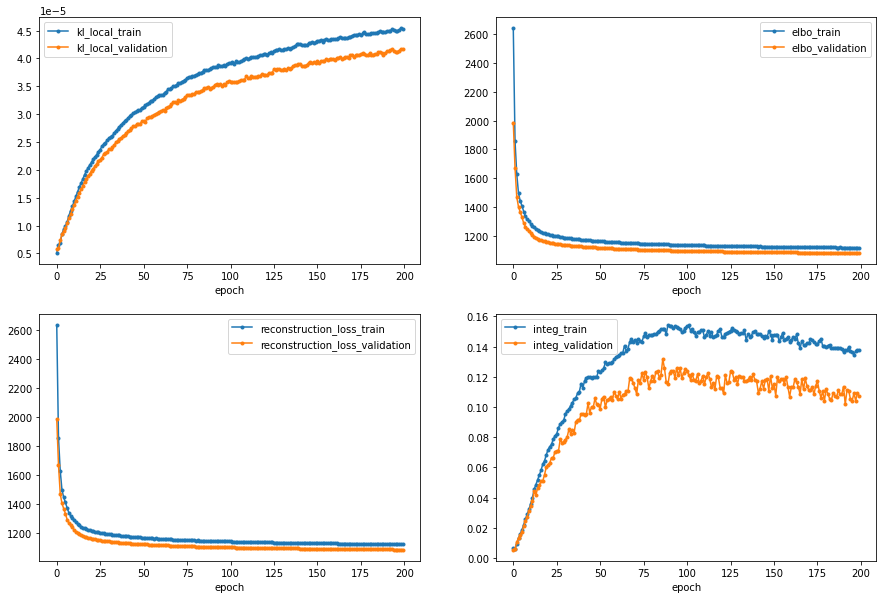

In [11]:
model.plot_losses()

# Inference

Get the latent representation.

In [12]:
model.get_latent_representation()
adata

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


AnnData object with n_obs × n_vars = 41482 × 4134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi'
    obsm: '_scvi_extra_categoricals', '_scvi_extra_continuous', 'latent'
    layers: 'counts'

Visualize results.

In [14]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)

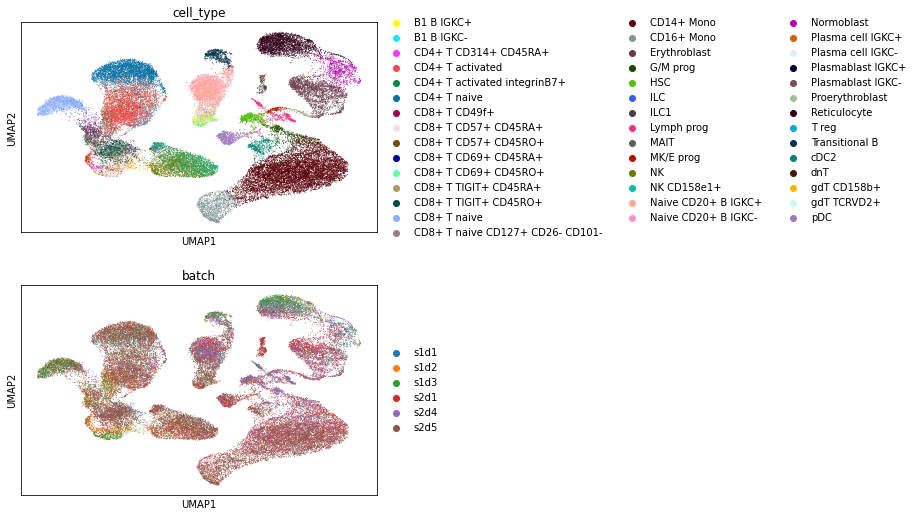

In [16]:
sc.pl.umap(adata, color=['cell_type', 'batch'], ncols=1)